## Introduction
In this project, I will show how one can finetune EfficientNet-B7 to detect Melanoma (a variety of skin cancer) from images. This problem is important because fast and accurate automated diagnosis can help reduce burden on doctors and let them focus on curing patients. I will use the Efficientnet to get the pretrained EfficientNet-B7 model on TPU. At the end, we will run inference on the test set and test the model's predictions on some sample images.

## Preparing the ground¶
In this section, we will prepare the ground to train and test the model by installing packages, setting hyperparameters, and loading the data.

In [1]:
!pip install -q efficientnet

## Import necessary libraries
Now, we import all the libraries we need.
colored, matplotlib, tqdm, and plotly for visualization.
numpy, pandas, torch, torchvision, albumentations, and efficientnet_pytorch for modelling.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder


import numpy as np
import pandas as pd 
import os
import re
import cv2
import math
import time
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
#from kaggle_datasets import KaggleDatasets

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px

## TPU Configuration

In [3]:
print("Tensorflow version " + tf.__version__)

AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
     
print("REPLICAS: ", strategy.num_replicas_in_sync)


GCS_PATH = '/Users/sangeetha/DataScienceProjects/malanoma project/512x512-melanoma-tfrecords-70k-images'


Tensorflow version 2.0.0
REPLICAS:  1


# Loading training and test dataset

In [4]:
train = pd.DataFrame(pd.read_csv("/Users/sangeetha/DataScienceProjects/malanoma project/train.csv"))
test = pd.DataFrame(pd.read_csv("/Users/sangeetha/DataScienceProjects/malanoma project/test.csv"))

# Exploratory Data Analysis

In [5]:
train.shape, test.shape

((33126, 8), (10982, 5))

### There are around 33k training images and about 10k testing images

In [6]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


#### Identifying nan values in train data

In [9]:
train.isna().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

#### Training set : Sex, age and anatomy_site have missing values.
      

In [10]:
test.isna().sum()

image_name                         0
patient_id                         0
sex                                0
age_approx                         0
anatom_site_general_challenge    351
dtype: int64

#### Test set : Anatomy_site have missing values.

## Drop nan in train dataset

In [11]:
train = train.dropna()

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32531 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     32531 non-null  object 
 1   patient_id                     32531 non-null  object 
 2   sex                            32531 non-null  object 
 3   age_approx                     32531 non-null  float64
 4   anatom_site_general_challenge  32531 non-null  object 
 5   diagnosis                      32531 non-null  object 
 6   benign_malignant               32531 non-null  object 
 7   target                         32531 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.2+ MB


## Drop nan in test dataset


In [12]:
test = test.dropna()

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10631 entries, 1 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10631 non-null  object 
 1   patient_id                     10631 non-null  object 
 2   sex                            10631 non-null  object 
 3   age_approx                     10631 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 498.3+ KB


#### Finding unique patient in the train and test dataset

In [13]:

train['patient_id'].nunique(), test["patient_id"].nunique()

(2051, 689)


This means that out of 33,126 registered entries in the training set, only 2,056 are unique implying that some patients are diagnosed with multiple marks.

Same goes for the test set where we have only 690 unique values out of collection of 10,982.

# Distribution Observation of data

In [14]:
print(train["target"].value_counts())

0    31956
1      575
Name: target, dtype: int64


## Malignant VS Benign cases - OVERALL

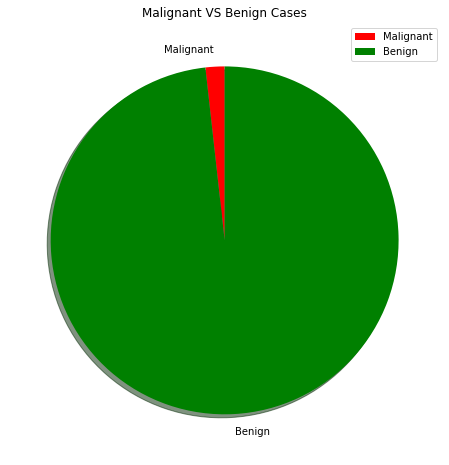

In [15]:
malignant = len(train[train["target"] == 1])
benign = len(train[train["target"] == 0])

labels = ["Malignant", "Benign"] 
size = [malignant, benign]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, shadow = True, startangle = 90, colors = ["r", "g"])
plt.title("Malignant VS Benign Cases")
plt.legend()

# Male VS Female Count


Number of males in training set =  16788
Number of females in training set=  15743
Number of males in testing set =  5951
Number of females in testing set=  4680


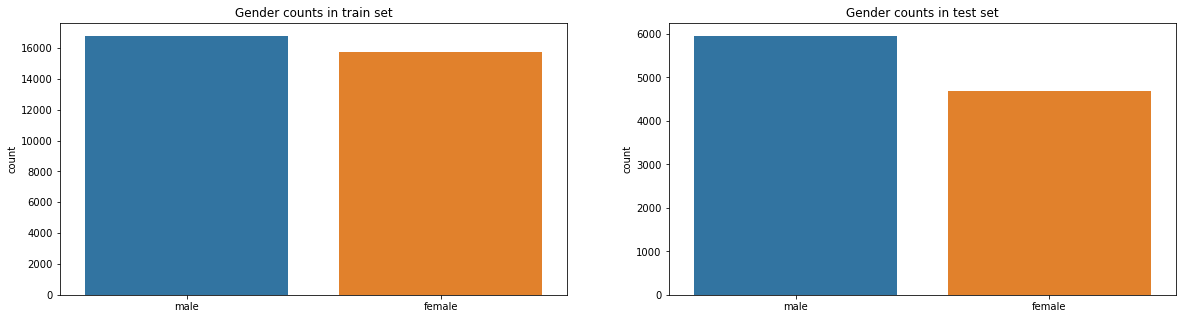

In [16]:
train_males = len(train[train["sex"] == "male"])
train_females  = len(train[train["sex"] == "female"])

test_males = len(test[test["sex"] == "male"])
test_females  = len(test[test["sex"] == "female"])
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(x='sex',data=train,ax=ax[0])
ax[0].set_xlabel(" ")
ax[0].set_title("Gender counts in train set")

print("Number of males in training set = ", train_males)
print("Number of females in training set= ", train_females)
sns.countplot(x='sex',data=test,ax=ax[1])
ax[1].set_xlabel(" ")
ax[1].set_title("Gender counts in test set")
print("Number of males in testing set = ", test_males)
print("Number of females in testing set= ", test_females)


##  Malignant male cases VS female cases

Malignant Male Cases =  358
Malignant Female Cases =  217


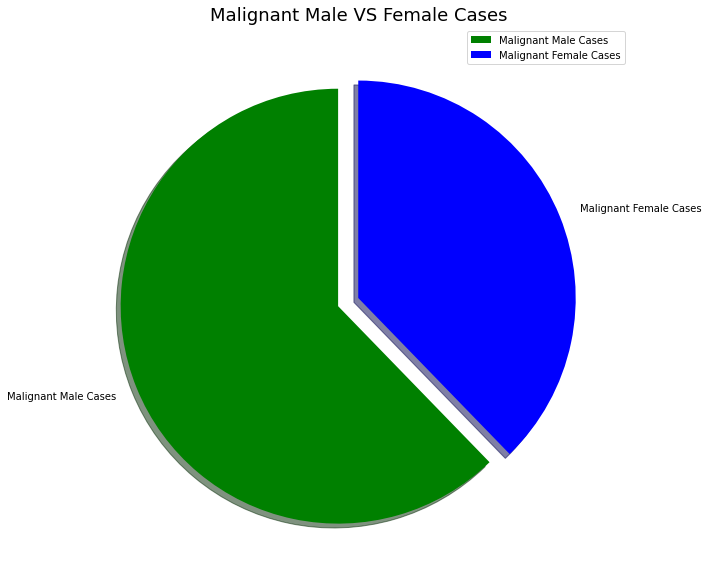

In [17]:
train_malignant  = train[train["target"] == 1]
train_malignant_males = len(train_malignant[train_malignant["sex"] == "male"])
train_malignant_females  = len(train_malignant[train_malignant["sex"] == "female"])

labels = ["Malignant Male Cases", "Malignant Female Cases"] 
size = [train_malignant_males, train_malignant_females]
explode = [0.1, 0.0]

plt.figure(figsize = (10, 10))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["g", "b"])
plt.title("Malignant Male VS Female Cases", fontsize = 18)
plt.legend()
print("Malignant Male Cases = ", train_malignant_males)
print("Malignant Female Cases = ", train_malignant_females)

# Benign male cases VS female cases

Benign Male Cases =  16430
Benign Female Cases =  15526


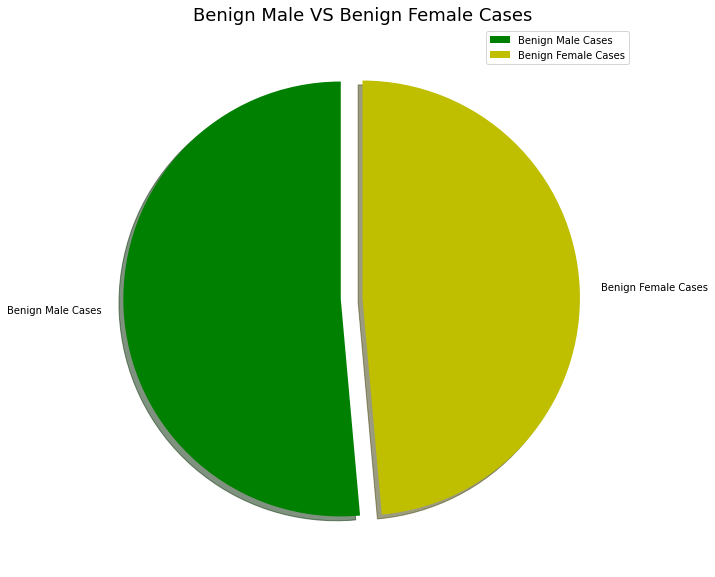

In [18]:
train_benign  = train[train["target"] == 0]

train_benign_males = len(train_benign[train_benign["sex"] == "male"])
train_benign_females  = len(train_benign[train_benign["sex"] == "female"]) 

labels = ["Benign Male Cases", "Benign Female Cases"] 
size = [train_benign_males, train_benign_females]
explode = [0.1, 0.0]

plt.figure(figsize = (10, 10))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["g", "y"])
plt.title("Benign Male VS Benign Female Cases", fontsize = 18)
plt.legend()
print("Benign Male Cases = ", train_benign_males)
print("Benign Female Cases = ", train_benign_females)

# Analysis of Cancer VS Sex

In [19]:
cancer_versus_sex = train.groupby(["benign_malignant","sex"]).size()
print(cancer_versus_sex)

benign_malignant  sex   
benign            female    15526
                  male      16430
malignant         female      217
                  male        358
dtype: int64


In [20]:
cancer_versus_sex = cancer_versus_sex.unstack(level = 1) / len(train) * 100
print(cancer_versus_sex)
print(type(cancer_versus_sex))

sex                  female       male
benign_malignant                      
benign            47.726784  50.505672
malignant          0.667056   1.100489
<class 'pandas.core.frame.DataFrame'>


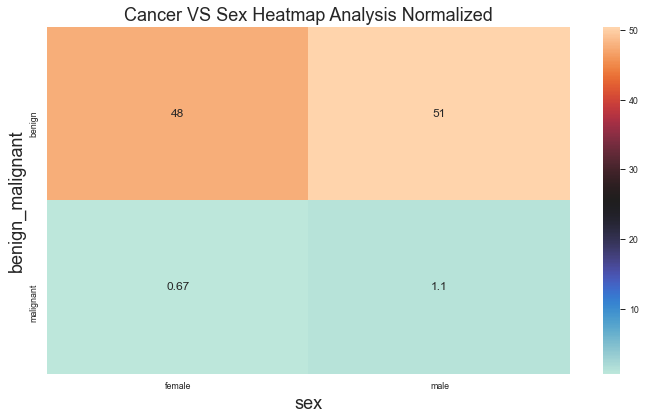

In [21]:
sns.set(style='whitegrid')
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":20,"axes.labelsize":18})   

plt.figure(figsize = (10, 6))
sns.heatmap(cancer_versus_sex, annot=True, cmap="icefire", cbar=True)
plt.title("Cancer VS Sex Heatmap Analysis Normalized", fontsize = 18)
plt.tight_layout()

# Analysing of Age Vs Cancer 

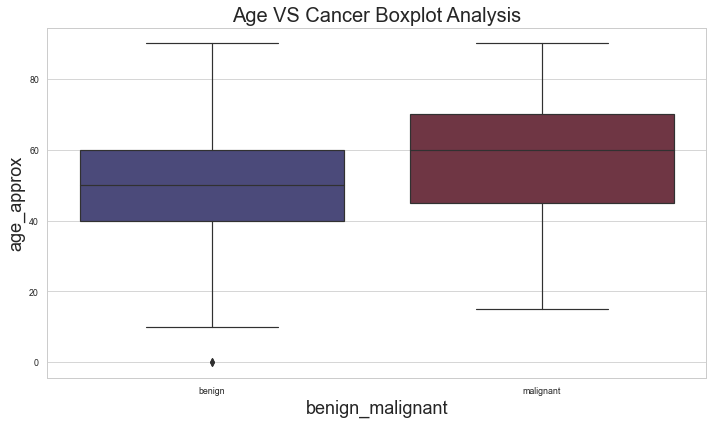

In [22]:
sns.set(style="whitegrid")
sns.set_context("paper", rc={"font_size":12,"axes.titlesize":20,"axes.labelsize":18})   
plt.figure(figsize = (10, 6))
sns.boxplot(train["benign_malignant"], train["age_approx"], palette="icefire")
plt.title("Age VS Cancer Boxplot Analysis")
plt.tight_layout()

### Inference :¶
* The malignant cases belong to relatively higher age group.
* Age might prove to be a contributing factor in deciding whether the case is malignant or benign.
* From sex analysis we can hypothesize that sex might be a deciding factor as well

# anatom_site_general_challenge

In [23]:
temp_train = train.anatom_site_general_challenge.value_counts().sort_values(ascending=False)
temp_test = test.anatom_site_general_challenge.value_counts().sort_values(ascending=False)
print("Anatom_Site valuecounts for train data",temp_train)
print("Anatom_Site valuecounts for test data",temp_test)



Anatom_Site valuecounts for train data torso              16825
lower extremity     8399
upper extremity     4963
head/neck           1845
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64
Anatom_Site valuecounts for test data torso              5847
lower extremity    2501
upper extremity    1573
head/neck           576
palms/soles         108
oral/genital         26
Name: anatom_site_general_challenge, dtype: int64


Text(0.5, 1.0, 'Image location in test set')

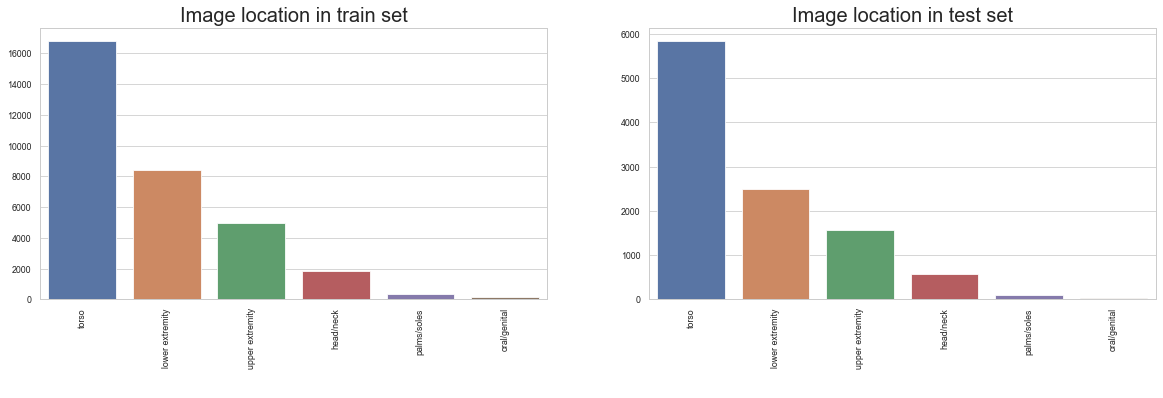

In [24]:

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=temp_train.index.values, y=temp_train.values,ax=ax[0])
ax[0].set_xlabel(" ")
labels = ax[0].get_xticklabels()
ax[0].set_xticklabels(labels, rotation=90)
ax[0].set_title("Image location in train set")

sns.barplot(x=temp_test.index.values, y=temp_test.values,ax=ax[1])
ax[1].set_xlabel(" ")
labels = ax[1].get_xticklabels()
ax[1].set_xticklabels(labels, rotation=90)
ax[1].set_title("Image location in test set")

### It seems like majority of the cases are observed at the torso, and after that the extremities of the body (upper/lower) in both the training and testing set.

# Age distribution in train and test dataset

Text(0.5, 1.0, 'Age distribution in test set')

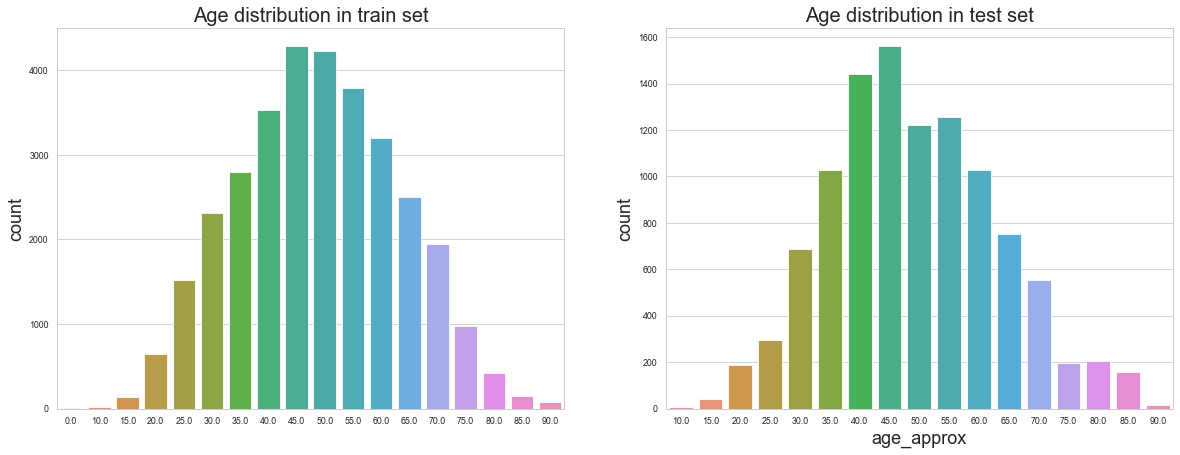

In [25]:
fig, ax =plt.subplots(1,2,figsize=(20,7))
sns.countplot(x="age_approx", data= train,ax=ax[0])
ax[0].set_xlabel("")
ax[0].set_title("Age distribution in train set")
sns.countplot(x="age_approx", data=test, ax=ax[1])
ax[0].set_xlabel("")
ax[1].set_title("Age distribution in test set")

Text(0.5, 1.0, 'Probabilistic Age Distribution In Training Set')

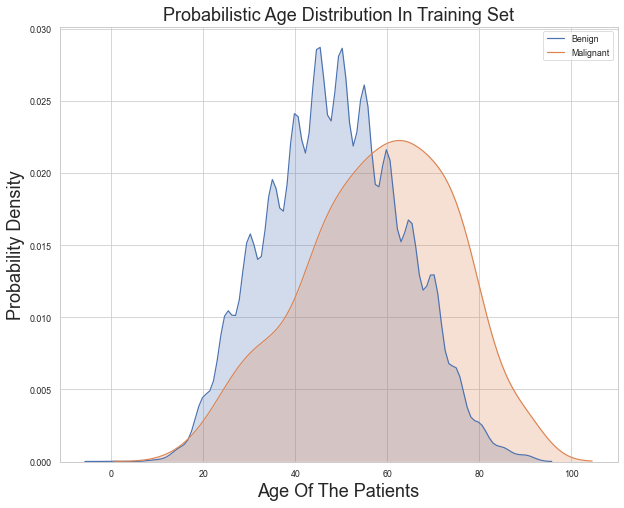

In [26]:
train_ages_benign = train.loc[train["target"] == 0, "age_approx"]
train_ages_malignant = train.loc[train["target"] == 1 , "age_approx"]

plt.figure(figsize = (10, 8))
sns.kdeplot(train_ages_benign, label = "Benign", shade = True, legend = True, cbar = True)
sns.kdeplot(train_ages_malignant, label = "Malignant", shade = True, legend = True, cbar = True)
plt.grid(True)
plt.xlabel("Age Of The Patients", fontsize = 18)
plt.ylabel("Probability Density", fontsize = 18)
plt.grid(which = "minor", axis = "both")
plt.title("Probabilistic Age Distribution In Training Set", fontsize = 18)

# Number of patients and samples

In [27]:
print('No of samples:  ' + str(train.image_name.nunique()))
print('No of patients: ' + str(train.patient_id.nunique()))

No of samples:  32531
No of patients: 2051


### No of samples taken from patients frequency
Observing the number of patients and no of total samples,I came to the follwoing insights.

All the patients gave at least 2 samples.
Maximum no of sample taken from a single patient is 115.
On an average each patient gave 16 samples
Median of samples of image per patient is 12
Mode of samples of image per patient is 2

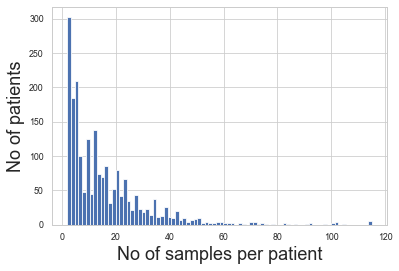

Minimum no of sample taken from  single patient 2
Maximum no of sample taken from  single patient 115
There are  15  samples taken from each patients on average
Median of no. of samples taken from  single patient 12
Mode of no. of samples taken from  single patient 3


In [28]:
image_freq_per_patient = train.groupby(['patient_id']).count()['image_name']
plt.hist(image_freq_per_patient.tolist(), bins = image_freq_per_patient.nunique())
plt.xlabel('No of samples per patient')
plt.ylabel('No of patients')
plt.show()
print('Minimum no of sample taken from  single patient', image_freq_per_patient.min())
print('Maximum no of sample taken from  single patient', image_freq_per_patient.max())
print('There are ',int( image_freq_per_patient.mean()), ' samples taken from each patients on average')
print('Median of no. of samples taken from  single patient', int(image_freq_per_patient.median()))
print('Mode of no. of samples taken from  single patient', int(image_freq_per_patient.mode()))

### Here we observe that among the unique patients providing samples,

Melanoma is more prevalant in Women
Among the Male patients, almost 24% are at malignant stage
On the other hand, among Femele patients, about 17% are at malignant stage

In [29]:
train.groupby(['benign_malignant', 'sex']).nunique()['patient_id']

benign_malignant  sex   
benign            female     976
                  male      1074
malignant         female     166
                  male       257
Name: patient_id, dtype: int64

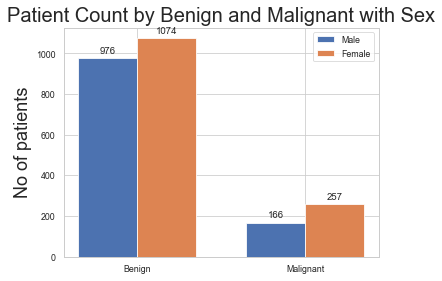

In [30]:
category_sex = train.groupby(['sex', 'benign_malignant']).nunique()['patient_id'].tolist()

labels = ['Benign', 'Malignant']
benign_data = category_sex[0:2]
maglignant_data = category_sex[2:4]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, benign_data, width, label='Male')
rects2 = ax.bar(x + width/2, maglignant_data, width, label='Female')
ax.set_ylabel('No of patients')
ax.set_title('Patient Count by Benign and Malignant with Sex')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

### One Hot Encoding¶
Transforming all categorical features un numerical.

Note1: sex, anatomy, diagnosis need to be encoded.

Note2: benign_malignant column will be dropped, as the information is already in the target column.

In [31]:
# === TRAIN ===
to_encode = ['sex', 'anatom_site_general_challenge', 'diagnosis']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(train[column])
    encoded_all.append(encoded)
    
train['sex'] = encoded_all[0]
train['anatom_site_general_challenge'] = encoded_all[1]
train['diagnosis'] = encoded_all[2]

if 'benign_malignant' in train.columns : train.drop(['benign_malignant'], axis=1, inplace=True)

In [32]:
# === TEST ===
to_encode = ['sex', 'anatom_site_general_challenge']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(test[column])
    encoded_all.append(encoded)
    
test['sex'] = encoded_all[0]
test['anatom_site_general_challenge'] = encoded_all[1]

In [33]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,target
0,ISIC_2637011,IP_7279968,1,45.0,0,8,0
1,ISIC_0015719,IP_3075186,0,45.0,5,8,0
2,ISIC_0052212,IP_2842074,0,50.0,1,5,0
3,ISIC_0068279,IP_6890425,0,45.0,0,8,0
4,ISIC_0074268,IP_8723313,0,55.0,5,8,0


# Loading the train and test images

In [34]:
image_names = train["image_name"].values
image_names = image_names + ".jpg"
image_names

array(['ISIC_2637011.jpg', 'ISIC_0015719.jpg', 'ISIC_0052212.jpg', ...,
       'ISIC_9999515.jpg', 'ISIC_9999666.jpg', 'ISIC_9999806.jpg'],
      dtype=object)

### We generate 4 random samples from the training data set. These 4 samples are taken from the aforementioned array of names.

In [35]:
random_images = [np.random.choice(image_names) for i in range(4)] # Generates a random sample from a given 1-D array
random_images

['ISIC_1779061.jpg',
 'ISIC_9250898.jpg',
 'ISIC_5136612.jpg',
 'ISIC_4803030.jpg']

## Sample Images

#### Earlier we extracted paths of all directories. So, we will access these images from there.

In [36]:
train_dir = "/Users/sangeetha/DataScienceProjects/malanoma project/train/"

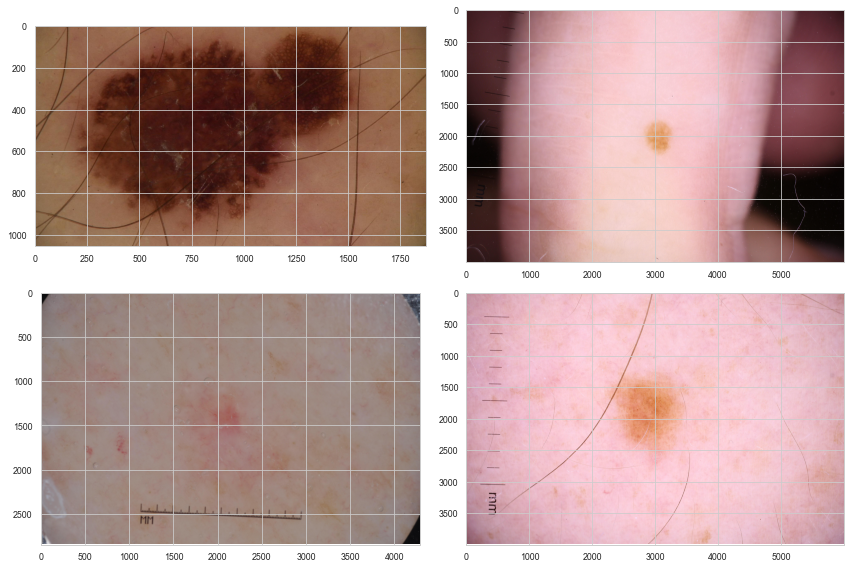

In [37]:
plt.figure(figsize = (12, 8))
for i in range(4) : 
    plt.subplot(2, 2, i + 1) 
    image = cv2.imread(os.path.join(train_dir, random_images[i]))
    # cv2 reads images in BGR format. Hence we convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap = "gray")
    plt.grid(True)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

## Analysis of color distribution

## Benign Cases :

Since we have a lot of images here, hence we randomly sample only a thousand of them.

In [38]:
# Benign Cases
benign = train[train["target"] == 0] 
image_names = benign["image_name"].values
image_names = image_names + ".jpg"
benign_image_list = [np.random.choice(image_names) for i in tqdm(range(1000))]

red = []
green = [] 
blue = []

for image_name in tqdm(benign_image_list) : 
    image = cv2.imread(os.path.join(train_dir, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mean_red = np.mean(image[:,:,0])
    mean_green = np.mean(image[:,:,1])
    mean_blue = np.mean(image[:,:,2])
    
    red.append(mean_red)
    green.append(mean_green)
    blue.append(mean_blue)

/Users/sangeetha/opt/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/Users/sangeetha/opt/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


## Skewness in EDA :
Skewness is the measure of symmetry or asymmetry of a data distribution. A distribution or data set is said to be symmetric if it looks same to the left and right point of the center.

Types of Skewness :
Skewness is generally classified into 2 broad categories-

Right skewness or Positive skewness
Left skewness or Negative skewness



## Kurtosis : Kurtosis is the characteristics of being flat or peaked. It is a measure whether data is heavy- tailed or light-tailed in a normal distribution

A large kurtosis value often mean that the tails of the distributions are getting toward more extreme values than the tails of normal distributions. This may lead to a length of 6 or 7 standard deviation from the mean. Similarly, If the kurtosis value is very low, then the tails of the distributions will be less lengthier than the those of a normal distribution (less than 3 standard deviation).

A large value of kurtosis is often considered as more risky because data may tend to give an outlier value as outcome with greater distance from the mean if applied to any machine learning algorithm.

Types of Kurtosis : 

It is very difficult to interpret and analyse the data which is skewed.

Some Transformations for highly skewed data : We can perform a number of transformations so that the data information remains preserved while at the same time some symmetric nature starts developing in its distribution.

Taking the square root of each data point and plotting it again. Taking the cube root of each data point and plotting it again. Taking the logarithm of each data point and plotting it again. Taking the reciprocal of each data point and plotting it again.

## Channel plotting for Benign cases

The range of spread = 174.49


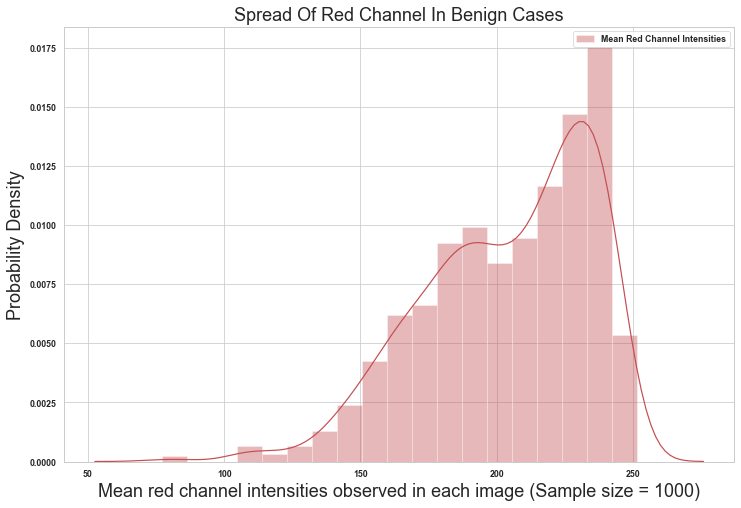

In [39]:
#red channel plot
range_of_spread = max(red) - min(red)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(red, hist = True, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig.set(xlabel = "Mean red channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density")
plt.title("Spread Of Red Channel In Benign Cases", fontsize = 18)
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

The range of spread = 207.12


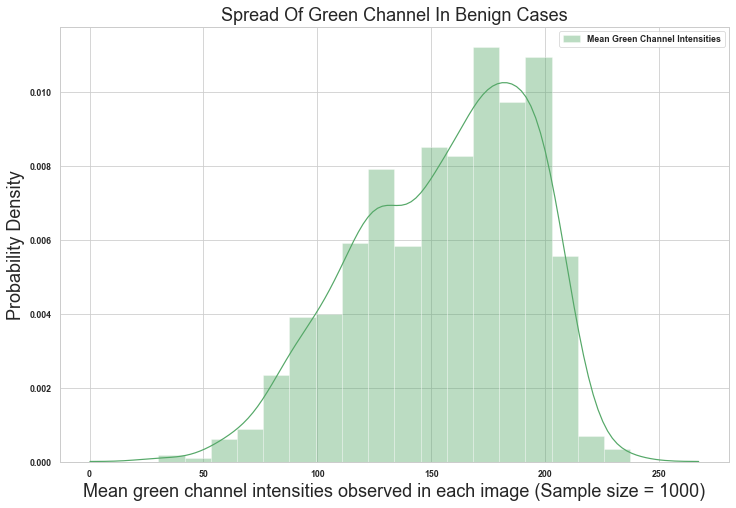

In [40]:
#green channel plot
range_of_spread = max(green) - min(green)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(green, hist = True, kde = True, label = "Mean Green Channel Intensities", color = "g")
fig.set(xlabel = "Mean green channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Green Channel In Benign Cases", fontsize = 18)
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

The range of spread = 234.17


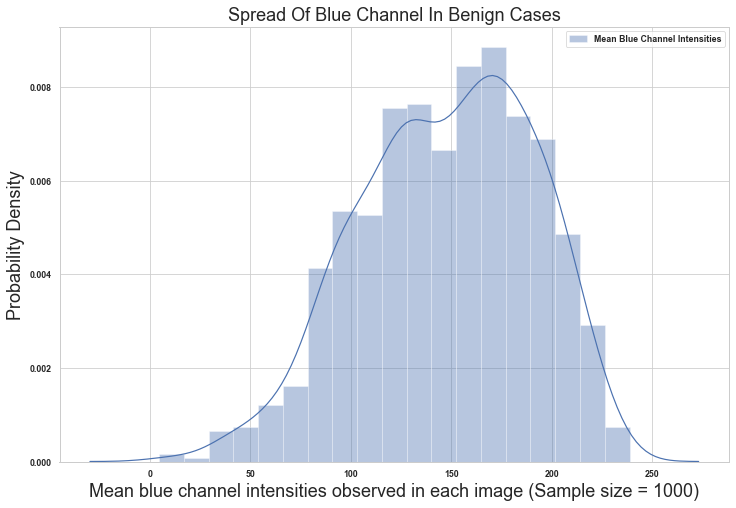

In [41]:
#Blue channel plot
range_of_spread = max(blue) - min(blue)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(blue, hist = True, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig.set(xlabel = "Mean blue channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Blue Channel In Benign Cases", fontsize = 18)
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))


###  Spread Of Channels In Benign Cases

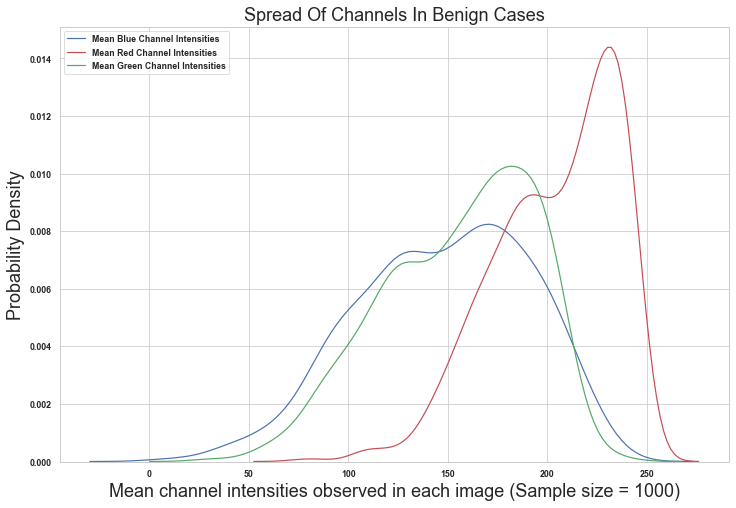

In [42]:
plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(blue, hist = False, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig = sns.distplot(red, hist = False, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig = sns.distplot(green, hist = False, kde = True, label = "Mean Green Channel Intensities", color = "g")

fig.set(xlabel = "Mean channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Channels In Benign Cases", fontsize = 18)
plt.legend()

# Malignant Cases

In [43]:
# free up the memory
del red
del green
del blue

In [44]:
import gc
gc.collect()

11185

In [45]:
# Malignant Cases
malignant = train[train["target"] == 1] 
image_names = malignant["image_name"].values
image_names = image_names + ".jpg"
benign_image_list = [np.random.choice(image_names) for i in tqdm(range(len(image_names)))]

red = []
green = [] 
blue = []

for image_name in tqdm(benign_image_list) : 
    image = cv2.imread(os.path.join(train_dir, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mean_red = np.mean(image[:,:,0])
    mean_green = np.mean(image[:,:,1])
    mean_blue = np.mean(image[:,:,2])
    
    red.append(mean_red)
    green.append(mean_green)
    blue.append(mean_blue)

/Users/sangeetha/opt/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/Users/sangeetha/opt/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


### Spread Of Channels In Malignant Cases

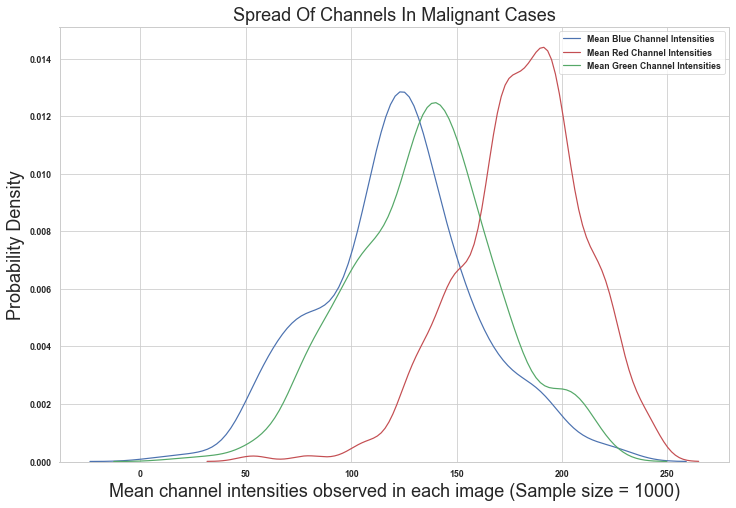

In [46]:
plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(blue, hist = False, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig = sns.distplot(red, hist = False, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig = sns.distplot(green, hist = False, kde = True, label = "Mean Green Channel Intensities", color = "g")

fig.set(xlabel = "Mean channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Channels In Malignant Cases", fontsize = 18)
plt.legend()

### So, we observe that in both the cases the component of red spikes the most, whereas Blue and Green are close to each other. All the channels also appears to be a bit negatively skewed.

### Hence, the channel distribution won't be a powerful feature to differentiate between the malignant and benign cases.**

Kutosis of this distribution is manageable.

In [47]:
gc.collect() # free up the memory

20

## Define hyperparameters and paths

In [ ]:
SEED = 42
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
SIZE = [512,512]
LR = 0.00004
EPOCHS = 12
WARMUP = 5
WEIGHT_DECAY = 0
LABEL_SMOOTHING = 0.05
TTA = 4

## Train and Test Data Filepath

In [ ]:
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

seed_everything(SEED)
train_filenames = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
test_filenames = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

In [ ]:
train_filenames,valid_filenames = train_test_split(train_filenames,test_size = 0.2,random_state = SEED)

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3) 
    image = tf.cast(image, tf.float32)/255.0
    image = tf.reshape(image, [*SIZE, 3])
    return image

def data_augment(image, label=None, seed=SEED):
    image = tf.image.rot90(image,k=np.random.randint(4))
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    if label is None:
        return image
    else:
        return image, label

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),  }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    return image, label 

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string), }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    image_name = example['image_name']
    return image, image_name

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = (tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
              .with_options(ignore_order)
              .map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO))
            
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def plot_transform(num_images):
    plt.figure(figsize=(30,10))
    x = load_dataset(train_filenames, labeled=False)
    image,_ = iter(x).next()
    for i in range(1,num_images+1):
        plt.subplot(1,num_images+1,i)
        plt.axis('off')
        image = data_augment(image=image)
        plt.imshow(image)

In [ ]:
plot_transform(7)

In [ ]:
train_dataset = (load_dataset(train_filenames, labeled=True)
    .map(data_augment, num_parallel_calls=AUTO)
    .shuffle(SEED)
    .batch(BATCH_SIZE,drop_remainder=True)
    .repeat()
    .prefetch(AUTO))

valid_dataset = (load_dataset(valid_filenames, labeled=True)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO))

## EfficientNetB7

In [ ]:
with strategy.scope():

    model = tf.keras.Sequential([
        efn.EfficientNetB7(input_shape=(*SIZE, 3),weights='imagenet',pooling='avg',include_top=False),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = LABEL_SMOOTHING),
        metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    

In [ ]:
model.summary()

## Learning Rate Schedules

In [ ]:
def get_cosine_schedule_with_warmup(lr,num_warmup_steps, num_training_steps, num_cycles=0.5):
    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return (float(epoch) / float(max(1, num_warmup_steps))) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

lr_schedule= get_cosine_schedule_with_warmup(lr=LR,num_warmup_steps=WARMUP,num_training_steps=EPOCHS)

In [ ]:
def train():
        STEPS_PER_EPOCH = count_data_items(train_filenames) // BATCH_SIZE
        history = model.fit(
            train_dataset, 
            epochs=EPOCHS, 
            callbacks=[lr_schedule],
            steps_per_epoch=STEPS_PER_EPOCH,
            validation_data=valid_dataset)

        string = 'Train acc:{:.4f} Train loss:{:.4f} AUC: {:.4f}, Val acc:{:.4f} Val loss:{:.4f} Val AUC: {:.4f}'.format( \
            model.history.history['accuracy'][-1],model.history.history['loss'][-1],\
            model.history.history['auc'][-1],\
            model.history.history['val_accuracy'][-1],model.history.history['val_loss'][-1],\
            model.history.history['val_auc'][-1])

        return string

In [ ]:
train()

## Prediction Based on Test Time Augmentation (TTA)
* Data augmentation technique for the test dataset, where multiple augmentaed copies of images in dataset is created with zoom, flip and shifts
* The artificially expanded training dataset can result in a more skillful model, as often the performance of deep learning models continues to scale in concert with the size of the training dataset
* The model makes prediction for each and then ensemble of the predictions are returned

In [ ]:
num_test_images = count_data_items(test_filenames)
submission_df = pd.read_csv('/Users/sangeetha/DataScienceProjects/malanoma project/sample_submission.csv')
for i in range(TTA):
    test_dataset = (load_dataset(test_filenames, labeled=False,ordered=True)
    .map(data_augment, num_parallel_calls=AUTO)  
    .batch(BATCH_SIZE))
    test_dataset_images = test_dataset.map(lambda image, image_name: image)
    test_dataset_image_name = test_dataset.map(lambda image, image_name: image_name).unbatch()
    test_ids = next(iter(test_dataset_image_name.batch(num_test_images))).numpy().astype('U')
    test_pred = model.predict(test_dataset_images, verbose=1) 
    pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(test_pred)})
    temp = submission_df.copy()   
    del temp['target']  
    submission_df['target'] += temp.merge(pred_df,on="image_name")['target']/TTA

In [ ]:
submission_df.to_csv('submission.csv', index=False)
pd.Series(np.round(submission_df['target'].values)).value_counts() 